In [247]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [248]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m

In [249]:
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

In [250]:
prices

,"BYBIT_STETH/USDT, 30_fd7e3","BYBIT_ETH/USDT, 30_1dfe3"
timestamp,,
2024-01-01 16:30:00,2312.58,2309.90
2024-01-01 17:00:00,2313.49,2314.71
2024-01-01 17:30:00,2311.86,2313.57
2024-01-01 18:00:00,2329.05,2329.38
2024-01-01 18:30:00,2325.79,2326.79
...,...,...
2024-12-31 21:30:00,3351.29,3352.69
2024-12-31 22:00:00,3333.82,3338.94
2024-12-31 22:30:00,3337.37,3339.99


# Trading simulation
---

* ## In-Sample Testing

In [251]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m


crypto_1 = prices.columns[0]
crypto_2 = prices.columns[1]

cointegrated_pairs = [(crypto_1,
  crypto_2,
  0.731393,
  0.8501886494196308,
  0.22)]

In [252]:
#Params:
window_size = 336
entry_threshold= 2
exit_threshold=0.1 
stop_loss_threshold= 100.0

In [253]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series,  win_indexs, loss_indexs, price_changes_S1, price_changes_S2 = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)
        
        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
        
        #pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BYBIT_STETH/USDT, 30_fd7e3 and BYBIT_ETH/USDT, 30_1dfe3 (pass_fractioon: 0.7314,average_p_value: 0.8502 correlation: 0.2200)
Total trades closed: 442 (Wins=442, Losses=0)
Win rate: 1.00


In [254]:
#Coefficient of variation
CV = spread_series.std()/abs(spread_series.mean())
CV

np.float64(41.704772404993626)

In [255]:
sym1

'BYBIT_STETH/USDT, 30_fd7e3'

In [256]:
price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

len(price_changes_S2_non_zero)

442

In [257]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost

trade_profits, cumulative_profit_series, entry_indices, exit_indices, long_spread_loss_count, short_spread_loss_count = simulate_strategy_trade_pnl(S1, S2, positions_series, beta_series, initial_capital,tx_cost)

In [258]:
long_spread_loss_count

112

In [259]:
#filter profits by positive values
print(np.mean(trade_profits))

1.6202504996552567


In [260]:
#Filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



Average trade loss:  € -1.6534791134246032
Average trade win:  € 4.749124820120962
Number of negative profits(profits that were less than the transaction cost):  216
Number of positive profits (profits that were greater than the transaction cost):  226


Text(0.5, 1.0, 'Returns Distribution for Pair BYBIT_STETH/USDT, 30_fd7e3 and BYBIT_ETH/USDT, 30_1dfe3')

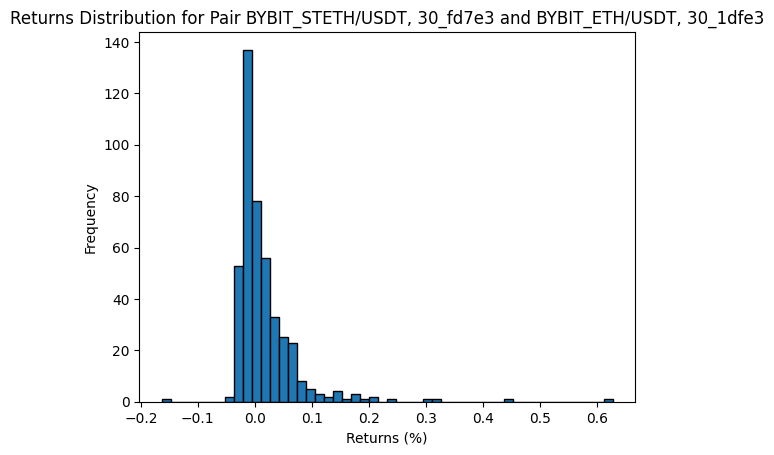

In [261]:
#Calculate returns based on the trade profits
trade_profits = np.array(trade_profits)
returns = trade_profits/initial_capital * 100

#Plot the returns
plt.hist(returns, bins=50, edgecolor='black')
plt.xlabel('Returns (%)')   
plt.ylabel('Frequency')
plt.title(f'Returns Distribution for Pair {sym1} and {sym2}') 

In [262]:
#Calculate percentage price changes for each asset
price_changes_S1 = np.array(price_changes_S1)

In [263]:
# daily_pnl_series, cum_pnl_series, cum_pnl_pct_series, shares_S1_list, shares_S2_list = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1_000)

# print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
# print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


In [264]:
#Obtain non-zero price changes
price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

#Convert price changes to percentage
price_changes_S1_non_zero_percent = [(x*100) for x in price_changes_S1_non_zero]
price_changes_S2_non_zero_percent = [(x*100) for x in price_changes_S2_non_zero]

#Print average price changes
print(f"Average price change S1: {np.mean(price_changes_S1_non_zero_percent)} %", f"Average price change S1: {np.mean(price_changes_S2_non_zero_percent)} %")
print(f"Number of trades: {len(price_changes_S1_non_zero)}")

Average price change S1: 0.03368202595753303 % Average price change S1: 0.09891814663706265 %
Number of trades: 442


Percentage return: 7.16 %


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_57180/54204168.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_return = cumulative_profit_series[-1]/initial_capital * 100


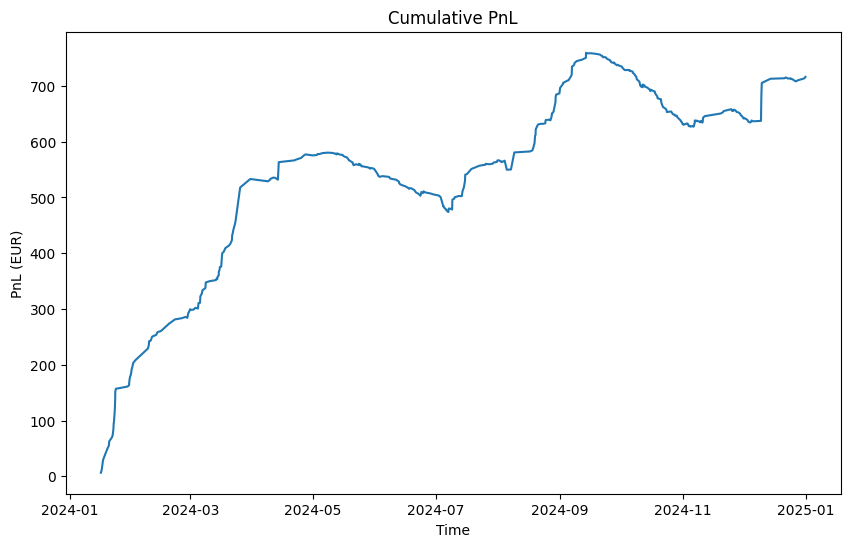

In [265]:
percentage_return = cumulative_profit_series[-1]/initial_capital * 100
print(f"Percentage return: {percentage_return:.2f} %")


#PROFIT SHOULD BE 0.15 EUR

plt.figure(figsize=(10,6))
plt.plot(cumulative_profit_series)
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL (EUR)')
plt.show()

In [266]:
cumulative_profit_series[-1]

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_57180/4263001124.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_profit_series[-1]


np.float64(716.1507208476233)

Long Entries In Window: 231, Short Entries In Window: 211
Wins In Window: 442, Losses In Window: 0


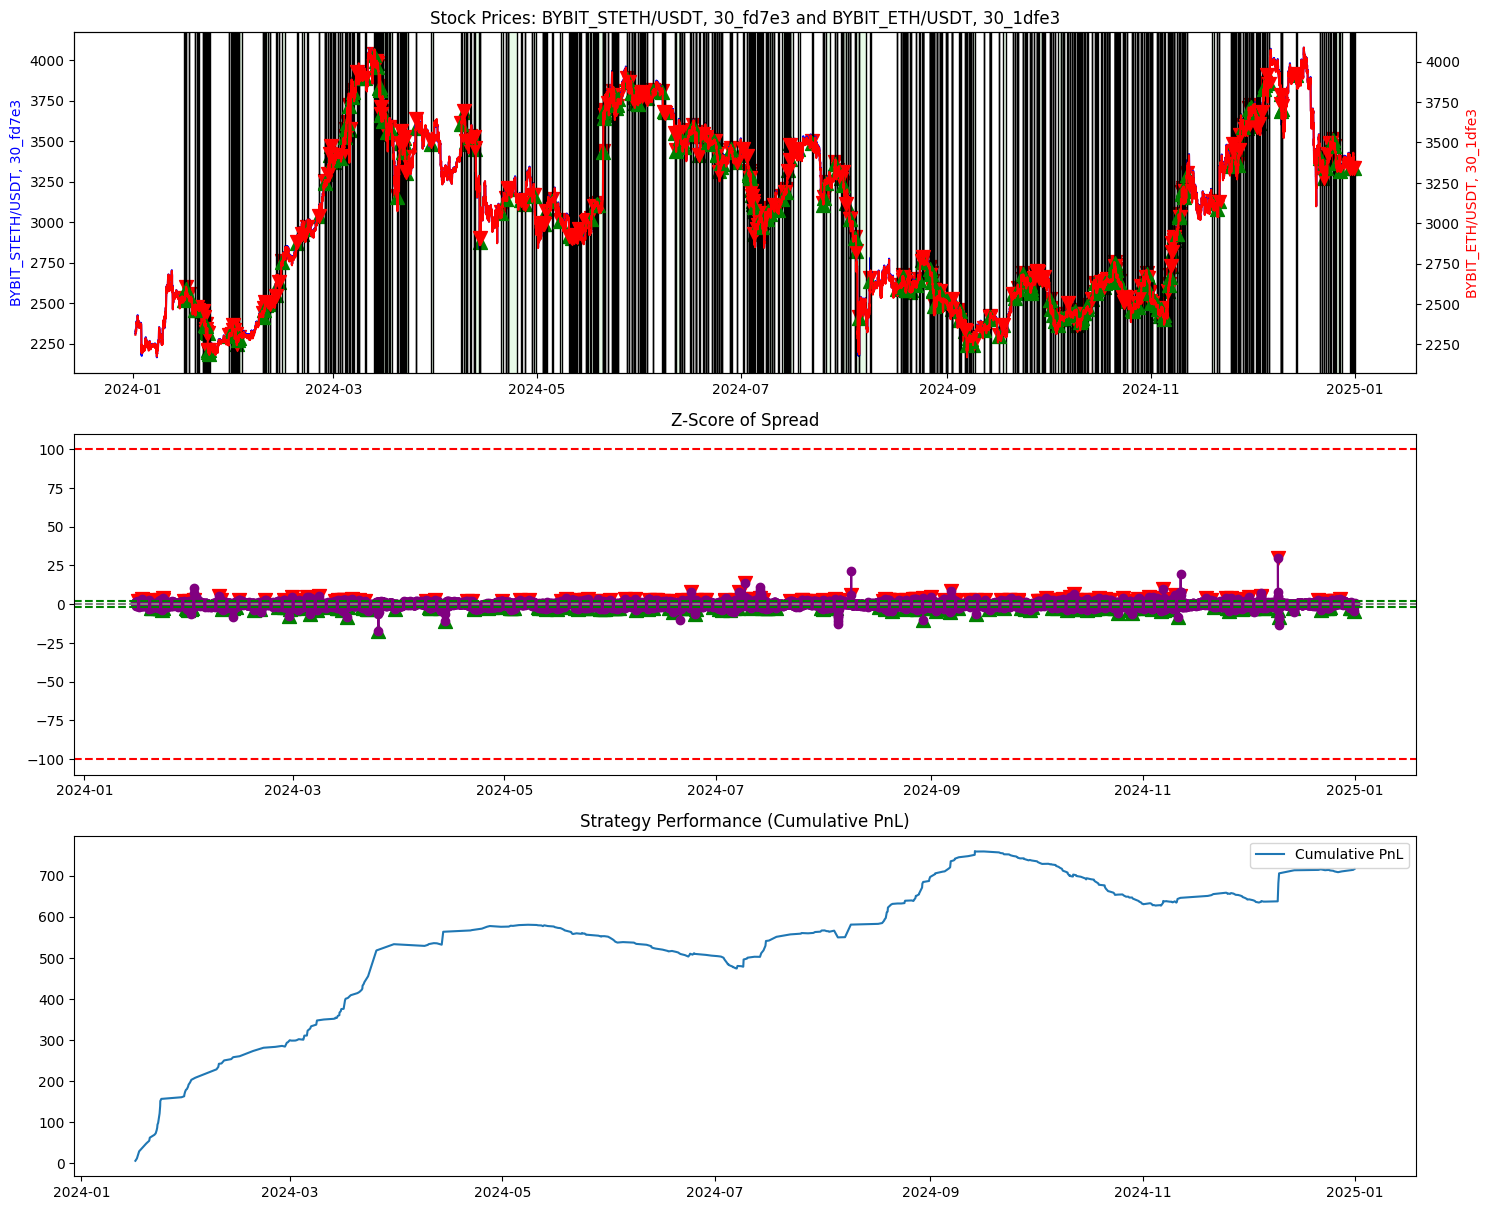

In [267]:
#Plot trading simulation
# window_start = '2023-10-03 00:00:00'
# window_end = '2023-10-03 10:00:00'


# window_start = '2024-01-22 00:00:00'
# window_end = '2024-01-24 00:00:00'

window_start = None
window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES


plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series,entry_threshold,stop_loss_threshold,
                        cumulative_profit_series,win_indexs=win_indexs,loss_indexs=loss_indexs,
                        window_start=window_start, window_end=window_end)



In [268]:
# First_trade_open_index = entry_indices[0]
# First_trade_close_index = exit_indices[0]

# #Get prices at the start and end of the first trade
# S1_price_start = S1[First_trade_open_index]
# S2_price_start = S2[First_trade_open_index]

# S1_price_end = S1[First_trade_close_index]
# S2_price_end = S2[First_trade_close_index]

# #Get the price changes
# S1_price_change = S1_price_end - S1_price_start
# S2_price_change = S2_price_end - S2_price_start

# #Get percentage price changes
# S1_price_change_percent = S1_price_change/S1_price_start * 100
# S2_price_change_percent = S2_price_change/S2_price_start * 100

# #Print results

# print(f"First trade open index: {First_trade_open_index}")
# print(f"First trade close index: {First_trade_close_index}")

# print(f"S1 price start: {S1_price_start}")
# print(f"S1 price end: {S1_price_end}")

# print(f"S2 price start: {S2_price_start}")
# print(f"S2 price end: {S2_price_end}")

# # #print percentage price changes
# # print(f"S1 price change: {S1_price_change}")
# # print(f"S2 price change: {S2_price_change}")

# print(f"S1 price change percent: {S1_price_change_percent}%")
# print(f"S2 price change percent: {S2_price_change_percent}%")

In [269]:


#Get prices at the start and end of the first trade
S1_price_start = S1[entry_indices]
S2_price_start = S2[entry_indices]

S1_price_end = S1.loc[exit_indices]
S2_price_end = S2.loc[exit_indices]


#Calculate the price changes by converting the series to numpy arrays
S1_price_start = S1_price_start.to_numpy()
S2_price_start = S2_price_start.to_numpy()

S1_price_end = S1_price_end.to_numpy()
S2_price_end = S2_price_end.to_numpy()

print("BEFORE ALIGNMENT")

#Make sure the arrays have the same shape
print(S1_price_start.shape)
print(S2_price_start.shape)


print(S1_price_end.shape)
print(S2_price_end.shape)


if S1_price_start.shape > S1_price_end.shape:
    S1_price_start = S1_price_start[:len(S1_price_end)]

if S2_price_start.shape > S2_price_end.shape:
    S2_price_start = S2_price_start[:len(S2_price_end)]
 
print("AFTER ALIGNMENT")

#Make sure the arrays have the same shape
print(S1_price_start.shape)
print(S2_price_start.shape)

print(S1_price_end.shape)
print(S2_price_end.shape)

#Get the price changes
S1_price_change = S1_price_end - S1_price_start
S2_price_change = S2_price_end - S2_price_start

#Get percentage price changes
S1_price_change_percent = S1_price_change/S1_price_start * 100
S2_price_change_percent = S2_price_change/S2_price_start * 100

#Get absolute percentage price changes
S1_price_change_percent_abs = np.abs(S1_price_change_percent)
S2_price_change_percent_abs = np.abs(S2_price_change_percent)



# #Get the price changes
# S1_price_change = S1_price_end - S1_price_start
# S2_price_change = S2_price_end - S2_price_start


BEFORE ALIGNMENT
(442,)
(442,)
(442,)
(442,)
AFTER ALIGNMENT
(442,)
(442,)
(442,)
(442,)


In [270]:
#Print average S1 price change percent rounded to 2 decimal places
print(f"Average absolute S1 price change percent: {np.mean(S1_price_change_percent_abs):.2f}%")
print(f"Average absolute S2 price change percent: {np.mean(S2_price_change_percent_abs):.2f}%")



Average absolute S1 price change percent: 0.75%
Average absolute S2 price change percent: 0.74%


(array([114.,  74.,  73.,  36.,  32.,  15.,  13.,  17.,   7.,   8.,  10.,
          4.,   9.,   4.,   5.,   5.,   5.,   0.,   1.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([2.89075825e-03, 1.66552015e-01, 3.30213271e-01, 4.93874528e-01,
        6.57535785e-01, 8.21197041e-01, 9.84858298e-01, 1.14851955e+00,
        1.31218081e+00, 1.47584207e+00, 1.63950332e+00, 1.80316458e+00,
        1.96682584e+00, 2.13048709e+00, 2.29414835e+00, 2.45780961e+00,
        2.62147086e+00, 2.78513212e+00, 2.94879338e+00, 3.11245463e+00,
        3.27611589e+00, 3.43977715e+00, 3.60343840e+00, 3.76709966e+00,
        3.93076092e+00, 4.09442217e+00, 4.25808343e+00, 4.42174469e+00,
        4.58540594e+00, 4.74906720e+00, 4.91272846e+00, 5.07638971e+00,
        5.24005097e+00, 5.40371223e+00, 5.56737348e+00, 5.73103474e+00,
        5.

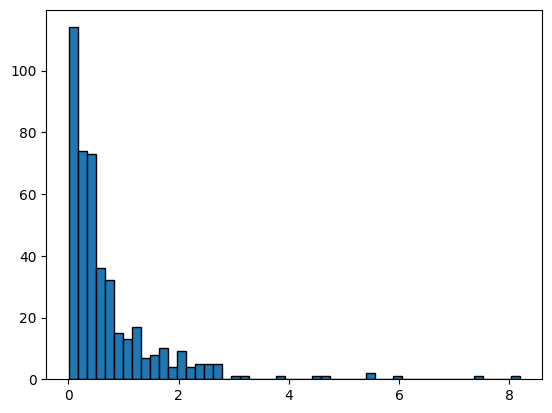

In [282]:
plt.hist(S1_price_change_percent_abs, bins=50, edgecolor='black')

In [273]:
trade_profits_percentage = trade_profits/initial_capital * 100

print(np.mean(trade_profits_percentage))

0.016202504996552566


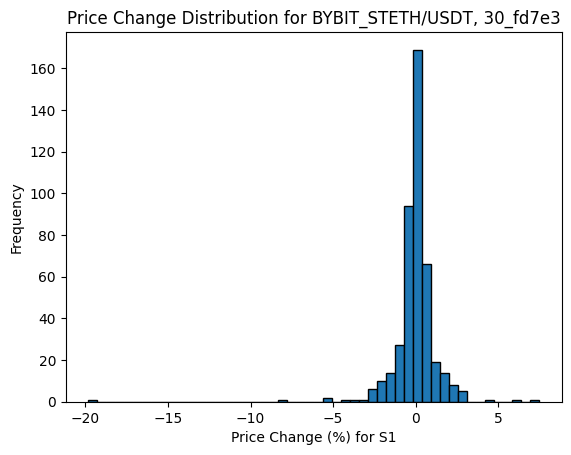

In [274]:
#Plot distribution of percentage price changes

plt.hist(S1_price_change_percent, bins=50, edgecolor='black')
plt.xlabel('Price Change (%) for S1')
plt.ylabel('Frequency')
plt.title(f'Price Change Distribution for {sym1}')
plt.show()

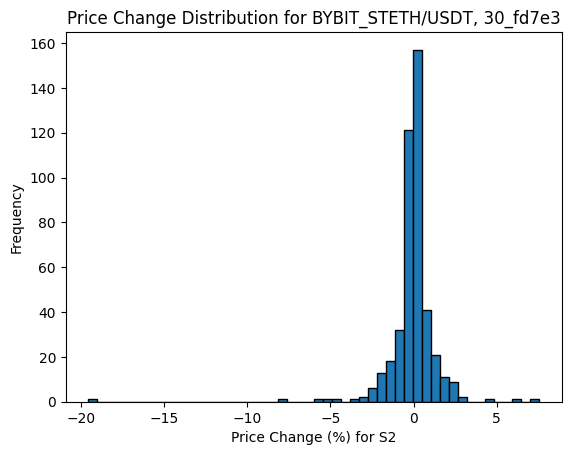

In [275]:
#Plot distribution of percentage price changes

plt.hist(S2_price_change_percent, bins=50, edgecolor='black')
plt.xlabel('Price Change (%) for S2')
plt.ylabel('Frequency')
plt.title(f'Price Change Distribution for {sym1}')
plt.show()

In [276]:
price_changes_S2_non_zero

[np.float64(0.005558722919042174),
 np.float64(-0.002340367287294606),
 np.float64(0.0004548948251791558),
 np.float64(-0.008038976857490939),
 np.float64(0.005416209942613988),
 np.float64(0.0028715120051914047),
 np.float64(0.0006796906796907093),
 np.float64(0.003019513242899371),
 np.float64(0.004148169403980379),
 np.float64(-0.01846771636901619),
 np.float64(0.008807495741056149),
 np.float64(-0.0017996890274807166),
 np.float64(0.01260113616801504),
 np.float64(0.002547133235354947),
 np.float64(0.002299623697940312),
 np.float64(-0.0006180051515465425),
 np.float64(0.022613730808924926),
 np.float64(-0.00263968132479829),
 np.float64(0.0012217047546843555),
 np.float64(-0.0017896588841000793),
 np.float64(-0.0034301269652646433),
 np.float64(-0.00012860302817271468),
 np.float64(0.0006024894350699505),
 np.float64(-0.0095380223202698),
 np.float64(0.001585183073527474),
 np.float64(-0.006579793295172962),
 np.float64(0.013898232053429768),
 np.float64(0.0025384480950716294),
 n

In [277]:
# plt.plot(spread_series.loc[window_start:window_end])
# plt.title('Spread Over Time')
# plt.legend()

In [278]:
# #zip S1 and S2 together
# S1_window = S1.loc[window_start:window_end]
# S2_window = S2.loc[window_start:window_end]

# #2023-10-23 22:43:00   -20.599535
# #compute spread

# rolling_mean_window = rolling_mean.loc[window_start:window_end]

# rolling_std_window = rolling_std.loc[window_start:window_end]

# spread_series_window = spread_series.loc[window_start:window_end]

# alpha_series_window = alpha_series.loc[window_start:window_end]

# z_score_window = zscore_series.loc[window_start:window_end]

# beta_series_window = beta_series.loc[window_start:window_end]

# #Merge dataframes together

# merged_df = pd.concat([S1_window,S2_window,spread_series_window,rolling_mean_window,rolling_std_window,alpha_series_window,z_score_window,beta_series_window],axis=1)

# merged_df.columns = ['S1','S2','Spread','Rolling Mean','Rolling Std','Alpha','Z Score','Beta']

# merged_df

In [279]:
# window_start = '2023-10-23 21:20:00'
# window_end = '2023-10-23 22:50:00'

# #Time of event: 2023-10-23 22:43:00	

# S1_window = S1[window_start:window_end]
# S2_window = S2[window_start:window_end]

# #Plot time series from window start to window end on different y axis and show data points



# fig, ax1 = plt.subplots()

# #Set size of the plot
# fig.set_size_inches(12, 8)

# color = 'tab:red'
# ax1.set_xlabel('Time')
# ax1.set_ylabel('S1', color=color)
# ax1.plot(S1_window, color=color, marker='o')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:blue'  
# ax2.set_ylabel('S2', color=color)
# ax2.plot(S2_window, color=color, marker='o')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Time series of S1 and S2 from window start to window end')






# # plt.plot(S1_window)
# # plt.plot(S2_window)
# # plt.title('Time series of S1 and S2 from window start to window end')
# # plt.show()

In [280]:
# spre = 31971.76 - (-2.096653) - 1.151277 * 28349.60
# spre